In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib as mpl
from pylab import rcParams

%matplotlib inline
from sklearn.metrics import confusion_matrix
from itertools import *
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import os
import shutil
import random
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
style.use('fivethirtyeight')
mpl.rcParams['figure.dpi']= 150
sns.mpl.rc("figure", figsize=(10, 6))

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  0


## Loading Data

Data was obtained from a [Kaggle competition](https://www.kaggle.com/c/dogs-vs-cats/data).

Let's organize the data into:
- Training Data
- Validation Data
- Testing Data

In [4]:
!ls

convolution_neural_animals.ipynb data


In [5]:
# change the directory to the dogs and cats directories
os.chdir('data/dogs-cats-data/')
# If the the train/dogs diretory does not exist then proceed to create some directories
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
    
    for e in random.sample(glob.glob('all_images/cat*'), 500):
        shutil.move(e,'train/cat')
    for e in random.sample(glob.glob('all_images/dog*'), 500):
        shutil.move(e,'train/dog')
    for e in random.sample(glob.glob('all_images/cat*'), 100):
        shutil.move(e,'valid/cat')
    for e in random.sample(glob.glob('all_images/dog*'), 100):
        shutil.move(e,'valid/dog')
    for e in random.sample(glob.glob('all_images/cat*'), 50):
        shutil.move(e,'test/cat')
    for e in random.sample(glob.glob('all_images/dog*'), 50):
        shutil.move(e,'test/dog')

In [6]:
os.chdir('../../')        

In [7]:
!ls

convolution_neural_animals.ipynb data


In [8]:
train_path = 'data/dogs-cats-data/train/'
valid_path = 'data/dogs-cats-data/valid/'
test_path = 'data/dogs-cats-data/test/'

In [9]:
# The images are passsed to the prerpocessing function before they get passed to the network
# target_size: it is the height and width of what we want the images to be resized to


train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory = train_path, target_size = (224,224), classes = ['cat', 'dog'], batch_size = 10)
valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory = valid_path, target_size = (224,224), classes = ['cat', 'dog'], batch_size = 10)
test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory = test_path, target_size = (224,224), classes = ['cat', 'dog'], batch_size = 10, shuffle = False)


Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [10]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [11]:
imgs, labels = next(train_batches)

In [12]:
def plotImages(images_arr):
    """
    A function that plots images in the form of a grid with 1 row and 10 columns where images
    are placed according the preproceed VGG16 model.
    Returns a skewed RGB data of the images, and the One-Hot Encoding of the cats as 1s and Dogs
    as 0s
    """
    fig, axes = plt.subplots(1,10, figsize = (20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

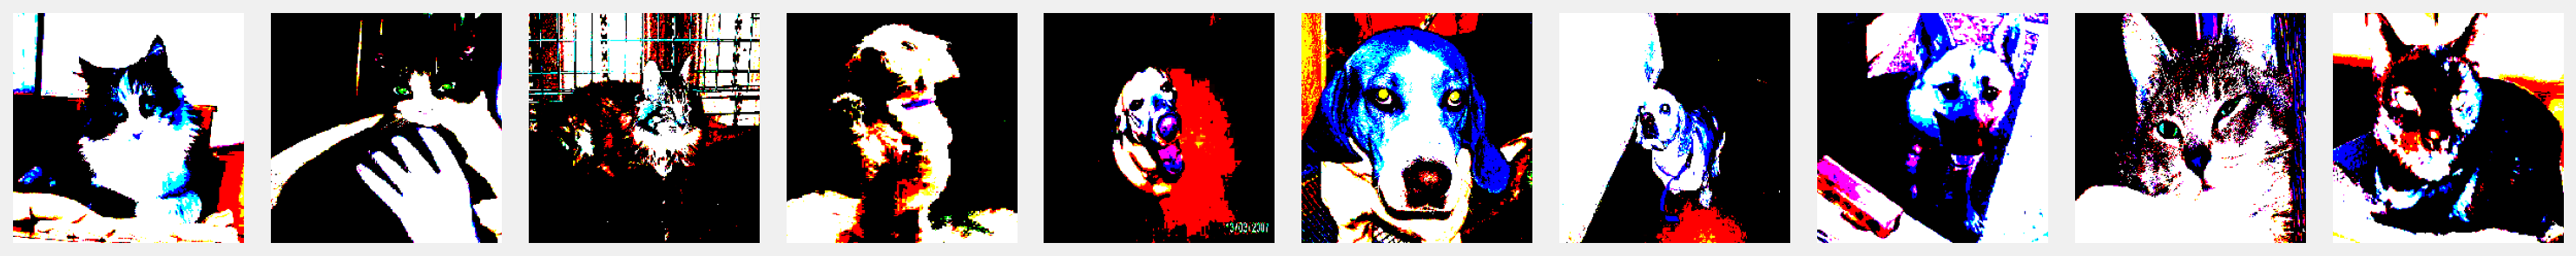

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [13]:
plotImages(imgs)
print(labels)

From the output we can still somewhat generalize and identify by eye which image belongs to cats and which one belongs to dogs.


However, if we take a look at the array of 1s and 0s, we can observe that is the [**One-Hot Encoder**](https://en.wikipedia.org/wiki/One-hot) of the classification of images. Representing the 1s as cats and the 0s as dogs. 

## Build and train a Convolution Neural Network

In [14]:
model = Sequential([
    Conv2D(filters = 32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters = 64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=2, activation = 'softmax'),
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [16]:
model.compile(optimzer= Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.fit(x=train_batches, validation_data = valid_batches, epochs=10, verbose=2)

Train for 100 steps, validate for 20 steps
Epoch 1/10
100/100 - 29s - loss: 43.8297 - accuracy: 0.5830 - val_loss: 0.6669 - val_accuracy: 0.6700
Epoch 2/10
100/100 - 28s - loss: 0.9778 - accuracy: 0.7630 - val_loss: 14.9721 - val_accuracy: 0.5050
Epoch 3/10
100/100 - 37s - loss: 1.4941 - accuracy: 0.8890 - val_loss: 1.7741 - val_accuracy: 0.6250
Epoch 4/10
100/100 - 37s - loss: 1.4157 - accuracy: 0.9110 - val_loss: 4.2006 - val_accuracy: 0.6300
Epoch 5/10
100/100 - 30s - loss: 1.2531 - accuracy: 0.9150 - val_loss: 3.8364 - val_accuracy: 0.6050
Epoch 6/10
100/100 - 30s - loss: 0.9664 - accuracy: 0.9550 - val_loss: 5.9017 - val_accuracy: 0.6250
Epoch 7/10
100/100 - 30s - loss: 2.4756 - accuracy: 0.9300 - val_loss: 11.3489 - val_accuracy: 0.6150
Epoch 8/10
100/100 - 30s - loss: 1.1609 - accuracy: 0.9500 - val_loss: 11.0668 - val_accuracy: 0.6100
Epoch 9/10
100/100 - 30s - loss: 1.9757 - accuracy: 0.9520 - val_loss: 11.5580 - val_accuracy: 0.6300
Epoch 10/10
100/100 - 30s - loss: 4.0564 - 

## Predict

Let's get a a batch of the Test Data in order to plot and print the labels for those images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

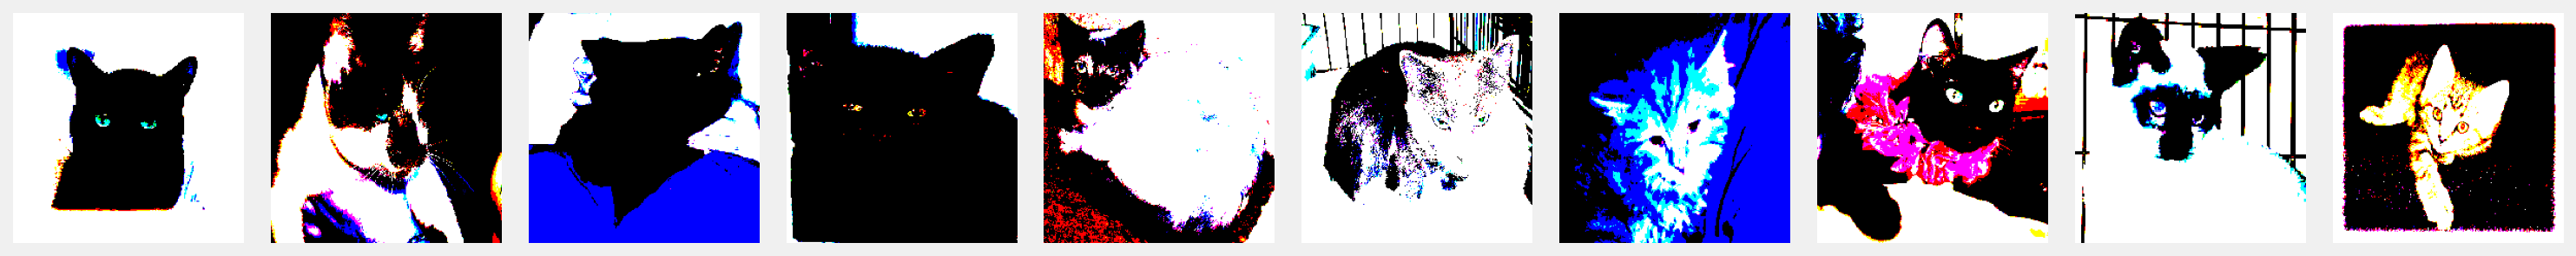

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [18]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

We see that they are all cats by looking at the One-Hot Encoding values.

##### Why only cats?

Because recall that when created the Test Set, the function above does not indicate that the images were shuffled. 

That way we can do the following:

In [19]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Above is an array of that has all of the correspoing labels for each image in the test set.

Given we hace access to the unshelled labels for the test set, **we don't want to shuffle the test set directly**.

We are interest in the *1-to-1* mapping from the unshuffled labels to the Test Data set. 

On the contrary, if we shuffle the Test Set, everytime we generated a batch, we wouldn't be able to have the correct mapping between labels and samples.

In [28]:
predictions = model.predict(x=test_batches, verbose=0)

Each of the below array is a prediction for the each sample.

Let's use a smaller example to understand:

Consider the following labels of the images
```
[[1. 0.]
 [1. 0.]
 [1. 0.]]
```
Now, consider a `predictions` array of the same size:
```
array([[0., 1.],
       [0., 1.],
       [1., 0.]])
```

The first and second array index is a `0`, which means model incorrectly predicted a label of a `1`.

The third array, on the other hand, it is predicting an output label of a `1` and indeed is a `1` in the original label classifyin images array of above.

In [29]:
np.round(predictions)

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

Now, we see it is a lot of work to compare array by array the difference between the original labels against the prediction labels. 

Thus, we will use a [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix) to provide a better sense of how well the predictions are made.

In [34]:
cm = confusion_matrix(y_true = test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Code Source: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.grid(False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [48]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[16 34]
 [ 7 43]]


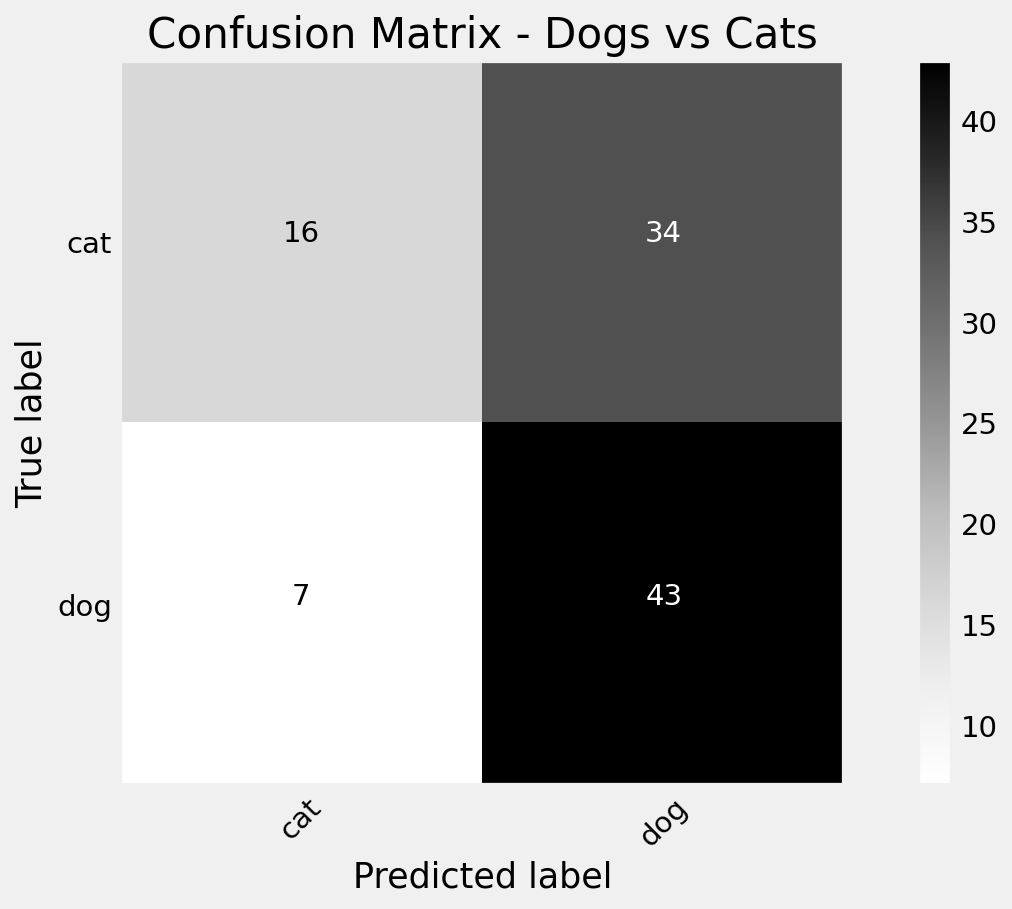

In [49]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title='Confusion Matrix - Dogs vs Cats')

- The model is overfitting and since we don't really care much about this one we don't have to be too concerned about 

---

## Build [VGG16](https://neurohive.io/en/popular-networks/vgg16/) Model

We will use this model now to compare how well this model classifies Dogs and Cats.

**VGG16** is a pre-trained model. In 2014, multiple teams competed against each other to build a model that best classifies images qithin the [**ImageNet**](http://www.image-net.org/) library. ImageNet is a database made of thousands of images that belong to 1000 different classes.

Let's use `Keras` to import the model and then proceed to fine tune it to not classify 1000 classes, instead let's just only classify dogs and cats. 

Since images of dogs and cats were included in the training of the model VGG16, let's write code that does not do much tuning to the model.

[This is the paper](https://arxiv.org/pdf/1409.1556.pdf) is where the VGG16 model was written on.

> The only preprocessing we do is subtracting the mean RGB value, computed on the training set, from each pixel. *Page 2, Very Deep Convolutional Networks for Large-Scale Image Recognition.*

This means that the authors of the VGG16 Model computed the mean red value pixel of all the training data, then with that value they had to substract that mean value across each image in the training set. They did the same thing for the blue and green mean pixel values  and subtract across all the training images respectively.

Now everytime new data is passed to the VGG16 Model, the data is preprocced in the exact same way.

### Download the model

Let's proceed to download the model from Internet. Need Wi-Fi or some sort of Internet connection to run the next cell.

In [51]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [52]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

There are:
```
Total params: 138,357,544
```

in this model

In [53]:
type(vgg16_model)

tensorflow.python.keras.engine.training.Model

This is `Model` type of data. However, this model comes from the Keras functional API. 

So far, we only used Sequential models. 

Let's convert the VGG16 model into Sequential model by looping through every layer and then add each layer into the new Sequential model.

In [56]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [57]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

They exactly the same, but the last layer has not been included in this made up model.

```
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 1000)              4097000   
=================================================================
```

Now,

```
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
=================================================================
```

In [ ]:
for layer in model.l